In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import broadcast
from pyspark.sql.types import *
import pandas as pd
import pandas as pd

# Loading Data

In [3]:
customer_courier = pd.read_excel('./project_dataset/sql_tables_sample/customer_courier_chat_messages.xlsx')
orders = pd.read_excel('./project_dataset/sql_tables_sample/orders.xlsx')
fake = pd.read_excel('./project_dataset/python_raw_data/fake_orders_test.xlsx')

In [4]:
customer_courier.head()

,sender_app_type,customer_id,from_id,to_id,chat_started_by_message,order_id,order_stage,courier_id,message_sent_time
0,Customer iOS,17071099,17071099,16293039,False,59528555,PICKING_UP,16293039,19/08/2019 08:03
1,Courier iOS,17071099,16293039,17071099,False,59528555,ARRIVING,16293039,19/08/2019 08:01
2,Customer iOS,17071099,17071099,16293039,False,59528555,PICKING_UP,16293039,19/08/2019 08:00
3,Courier Android,12874122,18325287,12874122,True,59528038,ADDRESS_DELIVERY,18325287,19/08/2019 07:59
4,Customer Android,13289990,13289990,18019844,False,59528038,ADDRESS_DELIVERY,18019844,25/12/2021 17:45


In [5]:
orders.head()

,order_id,city_code
0,59528555,BCN
1,59528038,MAD
2,59528292,BCN
3,59528179,BCN
4,59528318,MAD


In [6]:
fake.rename(columns={'activation_time_local: ': 'activation_time_local', 'products: ': 'products', 'products_total: ':'products_total'}, inplace=True)
fake.columns

Index(['order_id', 'activation_time_local', 'country_code', 'store_address',
       'final_status', 'payment_status', 'products', 'products_total',
       'purchase_total_price', 'pedidos'],
      dtype='object')

In [7]:
fake.head()

,order_id,activation_time_local,country_code,store_address,final_status,payment_status,products,products_total,purchase_total_price,pedidos
0,33557880,2019-03-10 23:59:59.000000,AR,14200,DeliveredStatus,PAID,1,4.540000e+00,8.640000e+00,1
1,33512615,2019-03-10 23:58:32.000000,TR,28725,DeliveredStatus,PAID,1,3.760000e+00,3.760000e+00,1
2,33512451,2019-03-10 23:57:56.000000,TR,28725,DeliveredStatus,PAID,1,2.860000e+16,2.860000e+16,1
3,33530892,2019-03-10 23:57:33.000000,ES,19777,CanceledStatus,PAID,1,1.295000e+01,0.000000e+00,1
4,33557765,2019-03-10 23:57:21.000000,AR,34565,DeliveredStatus,PAID,2,2.860000e+16,6.480000e+16,1


# Spark session

In [8]:
# Initialise Spark session
spark = SparkSession.builder.getOrCreate()

# Create a Spark dataframe from Pandas dataframe
messages = spark.createDataFrame(customer_courier)
messages.createOrReplaceTempView("messages")

your 131072x1 screen size is bogus. expect trouble
24/11/04 00:29:00 WARN Utils: Your hostname, DESKTOP-AEUBGUH resolves to a loopback address: 127.0.1.1; using 172.17.252.233 instead (on interface eth0)
24/11/04 00:29:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/04 00:29:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [19]:
# Display the first 10 rows
messages.show(10)

+----------------+-----------+--------+--------+-----------------------+--------+----------------+----------+-----------------+
| sender_app_type|customer_id| from_id|   to_id|chat_started_by_message|order_id|     order_stage|courier_id|message_sent_time|
+----------------+-----------+--------+--------+-----------------------+--------+----------------+----------+-----------------+
|    Customer iOS|   17071099|17071099|16293039|                  false|59528555|      PICKING_UP|  16293039| 19/08/2019 08:03|
|     Courier iOS|   17071099|16293039|17071099|                  false|59528555|        ARRIVING|  16293039| 19/08/2019 08:01|
|    Customer iOS|   17071099|17071099|16293039|                  false|59528555|      PICKING_UP|  16293039| 19/08/2019 08:00|
| Courier Android|   12874122|18325287|12874122|                   true|59528038|ADDRESS_DELIVERY|  18325287| 19/08/2019 07:59|
|Customer Android|   13289990|13289990|18019844|                  false|59528038|ADDRESS_DELIVERY|  1801

# KPIs

## 1. Percentage of Orders Cancelled by Country

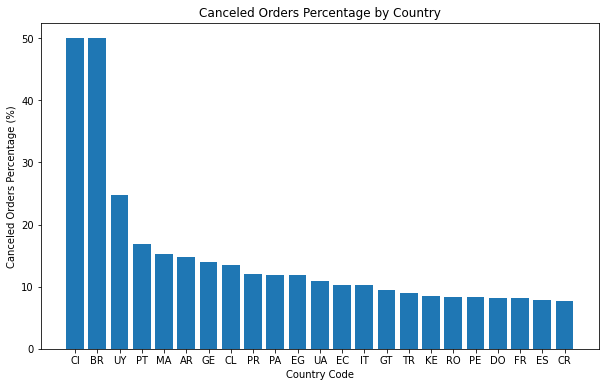

In [48]:
# Query to get canceled orders percentage by country
query_canceled_by_country = """
SELECT 
    country_code,
    ROUND((SUM(CASE WHEN final_status = 'CanceledStatus' THEN 1 ELSE 0 END) / COUNT(*)) * 100, 2) AS canceled_percentage
FROM fake_orders
GROUP BY country_code
ORDER BY canceled_percentage DESC
"""
canceled_by_country = spark.sql(query_canceled_by_country).toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(canceled_by_country['country_code'], canceled_by_country['canceled_percentage'])
plt.title("Canceled Orders Percentage by Country")
plt.xlabel("Country Code")
plt.ylabel("Canceled Orders Percentage (%)")
plt.savefig("./assets/orders_cancelled.jpg", bbox_inches='tight')
plt.show()

## 2. Average Purchase Total Price per Order by Country

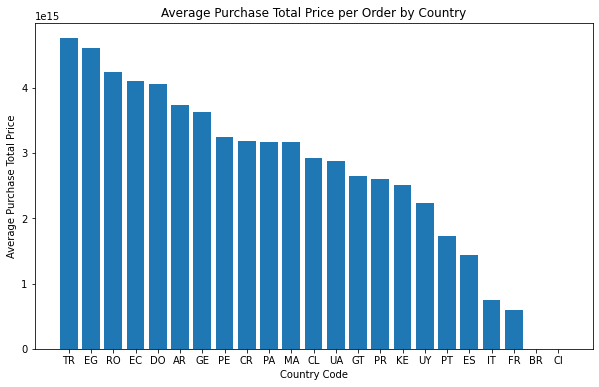

In [47]:
import matplotlib.pyplot as plt

# Query to get average purchase total price per order by country
query_avg_price_by_country = """
SELECT 
    country_code,
    ROUND(AVG(purchase_total_price), 2) AS avg_purchase_price
FROM fake_orders
GROUP BY country_code
ORDER BY avg_purchase_price DESC
"""
avg_price_by_country = spark.sql(query_avg_price_by_country).toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(avg_price_by_country['country_code'], avg_price_by_country['avg_purchase_price'])
plt.title("Average Purchase Total Price per Order by Country")
plt.xlabel("Country Code")
plt.ylabel("Average Purchase Total Price")
plt.savefig("./assets/average_purcharse.jpg", bbox_inches='tight')
plt.show()

## 3. Percentage of Orders with a Discrepancy Between `products_total` and `purchase_total_price` by Country

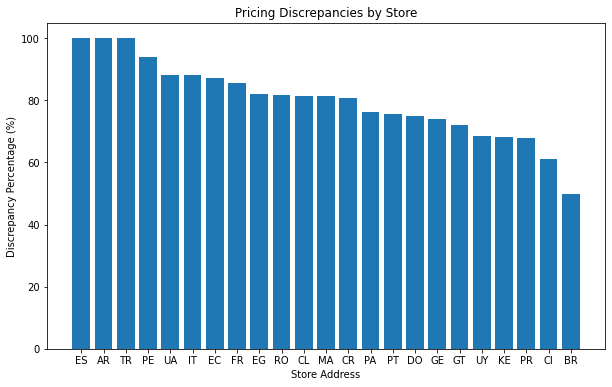

In [51]:
# Query to get discrepancy percentages by store
query_discrepancy_by_country = """
SELECT 
    country_code,
    SUM(CASE WHEN purchase_total_price != products_total THEN 1 ELSE 0 END) AS discrepancy_count,
    COUNT(*) AS total_orders
FROM fake_orders
GROUP BY country_code
ORDER BY discrepancy_count DESC
"""
discrepancy_by_country = spark.sql(query_discrepancy_by_country).toPandas()
discrepancy_by_country['discrepancy_percentage'] = (discrepancy_by_country['discrepancy_count'] / discrepancy_by_country['total_orders']) * 100

# Plot
plt.figure(figsize=(10, 6))
plt.bar(discrepancy_by_country['country_code'], discrepancy_by_country['discrepancy_percentage'].sort_values(ascending=False))
plt.title("Pricing Discrepancies by Store")
plt.xlabel("Store Address")
plt.ylabel("Discrepancy Percentage (%)")
plt.savefig("./assets/price_discrepancy.jpg", bbox_inches='tight')
plt.show()

# Query

In [10]:
result = spark.sql("""
WITH message_times AS (
    SELECT 
        order_id,
        -- Time of the first message from the customer
        MIN(CASE WHEN from_id = customer_id THEN message_sent_time END) AS first_customer_message_time,
        
        -- Time of the first message from the courier
        MIN(CASE WHEN from_id = courier_id THEN message_sent_time END) AS first_courier_message_time,
        
        -- Number of messages from the customer
        SUM(CASE WHEN from_id = customer_id THEN 1 ELSE 0 END) AS customer_message_count,
        
        -- Number of messages from the courier
        SUM(CASE WHEN from_id = courier_id THEN 1 ELSE 0 END) AS courier_message_count,
        
        -- First sender of the message
        CASE 
            WHEN MIN(CASE WHEN from_id = customer_id THEN message_sent_time END) < 
                 MIN(CASE WHEN from_id = courier_id THEN message_sent_time END) 
            THEN 'customer' 
            ELSE 'courier' 
        END AS first_sender,
        
        -- Time of the first message in the conversation
        MIN(message_sent_time) AS first_message_time,
        
        -- Time of the last message in the conversation
        MAX(message_sent_time) AS last_message_time
    FROM messages
    GROUP BY order_id
),
response_time AS (
    SELECT 
        m1.order_id,
        TIMESTAMPDIFF(
            SECOND,
            MIN(m1.message_sent_time),
            MIN(m2.message_sent_time)
        ) AS reaction_time
    FROM messages m1
    JOIN messages m2 ON m1.order_id = m2.order_id
                     AND m2.message_sent_time > m1.message_sent_time
                     AND m2.from_id != m1.from_id
    GROUP BY m1.order_id
),
last_stage AS (
    SELECT 
        order_id,
        order_stage AS last_message_stage
    FROM (
        SELECT 
            order_id,
            order_stage,
            ROW_NUMBER() OVER (PARTITION BY order_id ORDER BY message_sent_time DESC) AS rn
        FROM messages
    ) AS last_msg
    WHERE rn = 1
)
SELECT 
    mt.order_id,
    mt.first_customer_message_time,
    mt.first_courier_message_time,
    mt.customer_message_count,
    mt.courier_message_count,
    mt.first_sender,
    mt.first_message_time,
    mt.last_message_time,
    ls.last_message_stage
FROM message_times mt
JOIN response_time rt ON mt.order_id = rt.order_id
JOIN last_stage ls ON mt.order_id = ls.order_id
""")

# Save result as a table if needed
# result.write.saveAsTable("customer_courier_conversations")

In [11]:
result.show(15)

+--------+---------------------------+--------------------------+----------------------+---------------------+------------+------------------+-----------------+------------------+
|order_id|first_customer_message_time|first_courier_message_time|customer_message_count|courier_message_count|first_sender|first_message_time|last_message_time|last_message_stage|
+--------+---------------------------+--------------------------+----------------------+---------------------+------------+------------------+-----------------+------------------+
|59528111|           02/07/2021 13:25|          02/11/2019 06:14|                     3|                    3|    customer|  02/07/2021 13:25| 22/06/2020 21:57|          ARRIVING|
|59528214|           11/12/2019 01:33|          16/08/2021 00:23|                     2|                    1|    customer|  11/12/2019 01:33| 22/03/2021 23:10|          ARRIVING|
|59528420|                       NULL|          22/04/2019 05:06|                     0|            

# Fake Orders Queries

In [12]:
# Create a Spark dataframe from Pandas dataframe
fake_orders = spark.createDataFrame(fake)
fake_orders.createOrReplaceTempView("fake_orders")

## 1. Percentage of orders under-authorized

In [13]:
query_1 = """
SELECT 
    ROUND((SUM(CASE WHEN purchase_total_price < products_total THEN 1 ELSE 0 END) / COUNT(*)) * 100, 2) AS under_authorized_percentage
FROM fake_orders;
"""
response_1 = spark.sql(query_1).collect()

print(f"{response_1[0][0]}%\n")

26.87%



## 2. Percentage of orders with a 20% incremental authorization on the checkout amount

In [14]:
query_2 = """
SELECT 
    ROUND((SUM(CASE WHEN purchase_total_price >= products_total * 1.2 THEN 1 ELSE 0 END) / COUNT(*)) * 100, 2) AS incremental_authorized_percentage
FROM fake_orders;
"""
response_2 = spark.sql(query_2).collect()

print(f"{response_2[0][0]}%\n")

31.79%



## 3. Differences by country

In [15]:
query_3 = """
SELECT 
    country_code,
    ROUND((SUM(CASE WHEN purchase_total_price < products_total THEN 1 ELSE 0 END) / COUNT(*)) * 100, 2) AS under_authorized_percentage,
    ROUND((SUM(CASE WHEN purchase_total_price >= products_total * 1.2 THEN 1 ELSE 0 END) / COUNT(*)) * 100, 2) AS incremental_authorized_percentage
FROM fake_orders
GROUP BY country_code;
"""
response_3 = spark.sql(query_3).collect()

print("Answer:")

for row in response_3[:10]:
    print(f"Country: {row[0]}, Under-authorized Percentage: {row[1]}%, Incremental Authorized Percentage: {row[2]}%")
print("\n")

Answer:
Country: UA, Under-authorized Percentage: 25.71%, Incremental Authorized Percentage: 26.68%
Country: RO, Under-authorized Percentage: 27.5%, Incremental Authorized Percentage: 27.5%
Country: PT, Under-authorized Percentage: 33.55%, Incremental Authorized Percentage: 35.64%
Country: CL, Under-authorized Percentage: 12.95%, Incremental Authorized Percentage: 87.05%
Country: GT, Under-authorized Percentage: 19.58%, Incremental Authorized Percentage: 20.11%
Country: ES, Under-authorized Percentage: 27.16%, Incremental Authorized Percentage: 29.81%
Country: EC, Under-authorized Percentage: 26.71%, Incremental Authorized Percentage: 36.28%
Country: TR, Under-authorized Percentage: 23.19%, Incremental Authorized Percentage: 31.58%
Country: CR, Under-authorized Percentage: 33.15%, Incremental Authorized Percentage: 24.03%
Country: FR, Under-authorized Percentage: 28.04%, Incremental Authorized Percentage: 33.43%




## 4. Values necessary to capture the amount for the remaining orders that would fall outside of incremental authorization

In [16]:
query_4 = """
SELECT 
    order_id, 
    (products_total * 1.2) - purchase_total_price AS amount_needed_for_capture
FROM fake_orders
WHERE purchase_total_price < products_total * 1.2;
"""
response_4 = spark.sql(query_4).collect()

print("Answer:")

for row in response_4[:10]:
    print(f"Order ID: {row[0]}, Amount needed for capture: {row[1]}")
print("\n")

Answer:
Order ID: 33512615, Amount needed for capture: 0.7519999999999998
Order ID: 33512451, Amount needed for capture: 5720000000000000.0
Order ID: 33530892, Amount needed for capture: 15.54
Order ID: 33512273, Amount needed for capture: 0.2959999999999998
Order ID: 33524023, Amount needed for capture: 10.618
Order ID: 33511759, Amount needed for capture: 0.3939999999999997
Order ID: 33511416, Amount needed for capture: 0.786
Order ID: 33557565, Amount needed for capture: 3.1079999999999997
Order ID: 33557508, Amount needed for capture: 6.875999999999988e+16
Order ID: 33510806, Amount needed for capture: 0.8839999999999995




## 5. Most problematic stores in terms of order quantity and monetary value

In [17]:
query_5a = """
SELECT 
    store_address,
    COUNT(order_id) AS number_of_orders
FROM fake_orders
GROUP BY store_address
ORDER BY number_of_orders DESC
LIMIT 10;
"""
response_5a = spark.sql(query_5a).collect()

print("Most problematic stores in terms of order quantity")
for row in response_5a[:10]:
    print(f"Store: {row[0]}, Number of orders: {row[1]}")

query_5b = """
SELECT 
    store_address,
    SUM(purchase_total_price) AS total_value
FROM fake_orders
GROUP BY store_address
ORDER BY total_value DESC
LIMIT 10;
"""
response_5b = spark.sql(query_5b).collect()

print("\nMost problematic stores in terms of monetary value")

for row in response_5b[:10]:
    print(f"Store: {row[0]}, Total value: {row[1]}")
print("\n")

Most problematic stores in terms of order quantity
Store: 28671, Number of orders: 492
Store: 12513, Number of orders: 276
Store: 14455, Number of orders: 252
Store: 28675, Number of orders: 248
Store: 28712, Number of orders: 242
Store: 28286, Number of orders: 214
Store: 28669, Number of orders: 201
Store: 50832, Number of orders: 197
Store: 67084, Number of orders: 183
Store: 51363, Number of orders: 179

Most problematic stores in terms of monetary value
Store: 28286, Total value: 1.6295199999999987e+18
Store: 51363, Total value: 8.606700000000001e+17
Store: 62935, Total value: 8.533269999999997e+17
Store: 28285, Total value: 8.182599999999992e+17
Store: 66607, Total value: 7.767499999999999e+17
Store: 51374, Total value: 7.354099999999995e+17
Store: 11361, Total value: 7.333699999999999e+17
Store: 14455, Total value: 7.29140000000002e+17
Store: 11694, Total value: 6.307900000000003e+17
Store: 36698, Total value: 6.2369e+17




## 6. Correlation between price difference and order cancellation for under-authorized orders

In [18]:
query_6 = """
SELECT 
    AVG(products_total - purchase_total_price) AS avg_price_difference,
    AVG(CASE WHEN final_status = 'cancelled' THEN 1 ELSE 0 END) AS cancellation_probability
FROM fake_orders
WHERE purchase_total_price < products_total
GROUP BY (products_total - purchase_total_price);
"""
response_6 = spark.sql(query_6).collect()

print("Answer:")

for row in response_6[:10]:
    print(f"Average price difference: {row[0]}, Cancellation probability: {row[1]}")
print("\n")

Answer:
Average price difference: 8.51, Cancellation probability: 0.0
Average price difference: 0.8599999999999994, Cancellation probability: 0.0
Average price difference: 0.09999999999999964, Cancellation probability: 0.0
Average price difference: 6909999999999979.0, Cancellation probability: 0.0
Average price difference: 4.4799999999999995, Cancellation probability: 0.0
Average price difference: 1.7599999999999998, Cancellation probability: 0.0
Average price difference: 7209999999999981.0, Cancellation probability: 0.0
Average price difference: 19.27, Cancellation probability: 0.0
Average price difference: 5.86, Cancellation probability: 0.0
Average price difference: 8959999999999991.0, Cancellation probability: 0.0


